# Coverage Analysis

This notebook contains the research that was undertaken to find out over which time frame exactly an image of the entire federal state of Brandenburg can be generated. It contains various plots showing products available at a given point in time and details the tiling grid in which the Sentinel-2 data is provided.

The geometry of the area of interest is fetched from OpenStreetMap:

<AxesSubplot:>

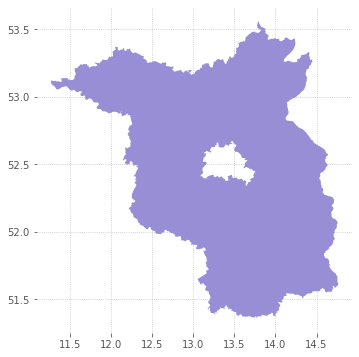

In [1]:
from pathlib import Path
from sentinel_helpers import search_osm

resources = Path('resources')

brandenburg = search_osm('Brandenburg, Germany')[:1]
# save geometry for later
brandenburg.to_file(resources / 'brandenburg.geojson', driver='GeoJSON')
brandenburg.plot(figsize=(6,6))

The products to be analyzed are all Sentinel-2 products at processing level 2A in the four weeks leading up to July 1 2020:

In [2]:
from datetime import date, timedelta
import os
from sentinelsat import SentinelAPI

end_date = date(2020, 7, 1)
start_date = end_date - timedelta(weeks=4)

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

# use simplified geometry
footprint = brandenburg.convex_hull[0].wkt

# send query
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date))
products = api.to_geodataframe(products)

Querying products: 100%|██████████| 181/181 [00:01<00:00, 50.95 products/s]
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


All available products are plotted to verify if there are enough products to cover our area of interest without holes.
As the revisit frequency given by the Sentinel-2 mission is much lower than four weeks this should not be a problem.

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

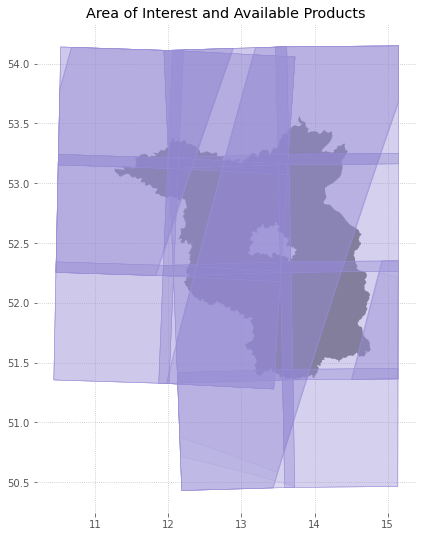

In [3]:
from sentinel_helpers import plot_downloaded_products
plot_downloaded_products(products, brandenburg, figsize=(9,9))

The darker an area, the more overlapping products, possibly at different points in time, contain data for that area. The plot shows that for some areas more data is available than for others.

## UTM Tile Numbers

Each tile has a distinct UTM tile reference number which is encoded in the product identifier as explained in [](01a-download-process.ipynb):

In [4]:
products['tile'] = products['identifier'].map(lambda s: s.split('_')[5])
products['tile'].head()

eb1fec8e-d933-48c3-99f2-c2b3731dc5a1    T33UUS
a87c7ff5-8664-4002-9258-7b1508a1de78    T33UUT
f07d56ae-df3c-4402-a63d-e3879e4e671d    T33UVV
6c1721a4-3628-49dd-a312-788111bf2ce9    T33UVU
8c3b2e01-7c8b-43d4-b3e0-1a6a376cdd65    T33UVT
Name: tile, dtype: object

Some UTM tiles start with `T32` while others start with `T33`:

In [5]:
products['tile'].groupby(products['tile'].str[:3]).count()

tile
T32     75
T33    106
Name: tile, dtype: int64

The tiling grid of Level 2A products is based on the Universal Transverse Mercator (UTM) Coordinate Reference System.

> The UTM system divides the Earth's surface into 60 zones. Each UTM zone has a vertical width of 6° of longitude and horizontal width of 8° of latitude.

Source: [Sentinel-2 User Guide](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/news/-/asset_publisher/Ac0d/content/sentinel-2-level-1c-product-tiling-grid-released)

Each of the rectangles resulting from this subdivision is again subdivided into equilateral and perfectly aligned squares, where each square is a product available from the API:

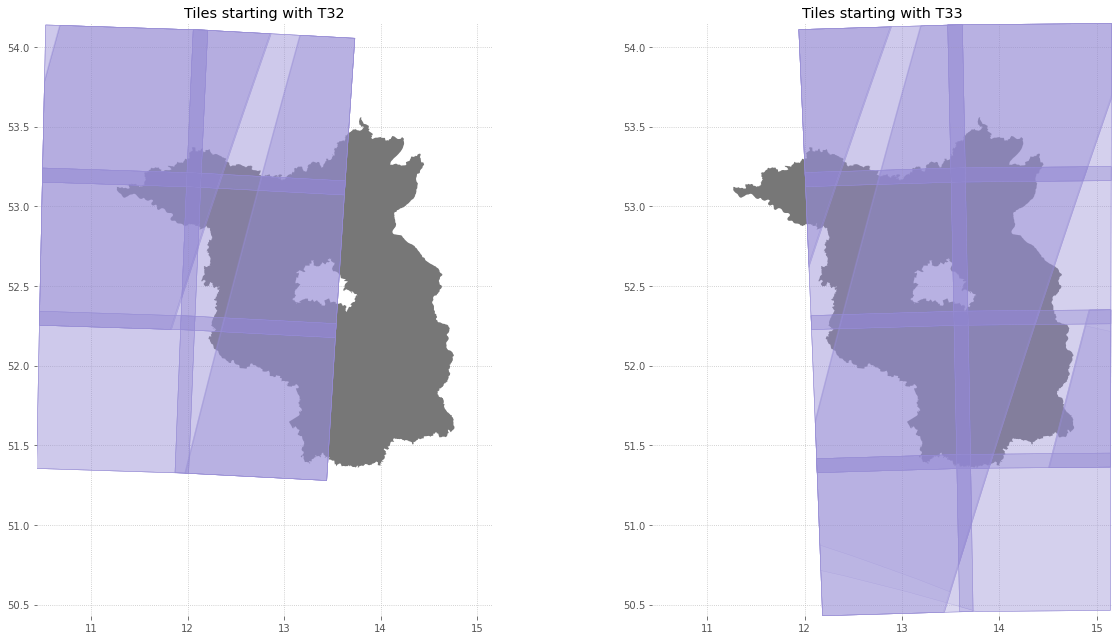

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,9))

# let both plots show the exact same area
bounds = products.unary_union.bounds
ax1.set_xlim(xmin=bounds[0], xmax=bounds[2])
ax1.set_ylim(ymin=bounds[1], ymax=bounds[3])
ax2.set_xlim(xmin=bounds[0], xmax=bounds[2])
ax2.set_ylim(ymin=bounds[1], ymax=bounds[3])

# subset tiles per plot
t32_tiles = products[products['tile'].str.startswith('T32')]
t33_tiles = products[products['tile'].str.startswith('T33')]

# plot subset of tiles left and right
ax1.set_title('Tiles starting with T32')
ax2.set_title('Tiles starting with T33')
plot_downloaded_products(t32_tiles, brandenburg, ax=ax1)
plot_downloaded_products(t33_tiles, brandenburg, ax=ax2)
plt.tight_layout()

Adjacent rectangles are not perfectly parallel.
This is because of choices that have to be made when projecting from the earths spherical surface to a rectangular plane.
The UTM grid is constructed so that coordinates within each tiling represent metrical distances on the earths surface.
This has the nice property that in order to areas and surfaces within a UTM tiling can be calculated simply by counting.

(content:orbits)=
## Product Shape and Orbit Number

As mentioned above, each square is a single product that can be downloaded from the Copernicus Open Access Hub.
The visualizations above and the true color rendering in [](01b-visualization.ipynb) shows that these products are not often not perfect squares, but that they have missing slices.

This is because of the satellite orbit at the time of capturing the data.
To visualize this we plot the available products per orbit:

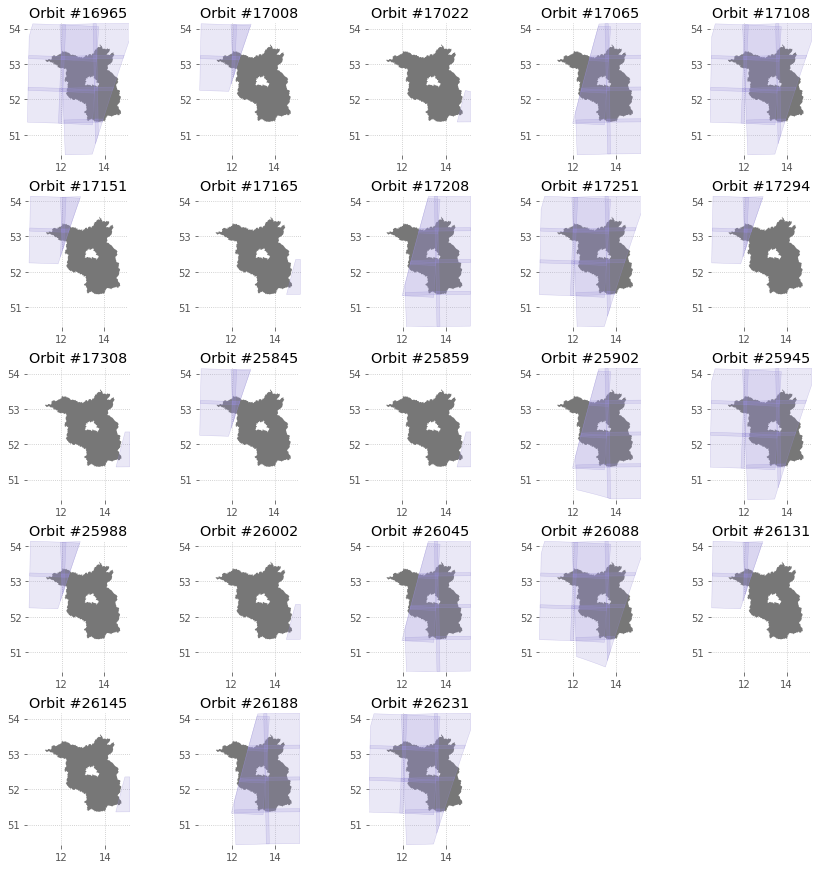

In [7]:
import math

orbits = products['orbitnumber'].unique()

ncols = 5
fig, axs = plt.subplots(nrows=math.ceil(len(orbits) / ncols), ncols=ncols, figsize=(12, 12))
fig.tight_layout(h_pad=2) # h_pad=2 works better if we have titles in our subplots
axs = axs.flatten() # lets us address a subplot with a 1d index

for ax, orbit in zip(axs, sorted(orbits)):
    ax.set_title('Orbit #{}'.format(orbit))
    ax.set_xlim(xmin=bounds[0], xmax=bounds[2])
    ax.set_ylim(ymin=bounds[1], ymax=bounds[3])
    per_orbit = products[products['orbitnumber'] == orbit]
    plot_downloaded_products(per_orbit, brandenburg, ax=ax, alpha=0.2)
    
# hide empty subplots
for ax in axs[len(orbits):]:
    ax.axis('off')

Looking at the plot above we can see a repeating pattern.
Orbits #16965, #17108, #17251, #25945, #26088 and #26231 cover the same shape.
The same can be said for the other slices, which repeat at the same frequencies.
Except for the jump in orbit number from of roughly 8000 from 17xxx to 25xxx, the cycle repeats every 143 orbits.

The orbit number jump can be explained because they counted per Sentinel-2 satellite. There are currently two satellites in the Sentinel-2 program, S2A and S2B. These can be identified using the product `title`:

In [8]:
products['title'].apply(lambda t: t.split('_')[0]).unique()

array(['S2A', 'S2B'], dtype=object)

S2A has been launched earlier, which is why the orbit numbers are higher:

In [9]:
products[products['title'].str.startswith('S2A')]['orbitnumber'].unique()

array([26231, 26188, 26145, 26131, 26088, 26045, 26002, 25988, 25945,
       25902, 25859, 25845])

Compared to the orbit numbers of the S2B satellite:

In [ ]:
products[products['title'].str.startswith('S2B')]['orbitnumber'].unique()

## Ensuring Complete Coverage

If we do not want to wait an entire repeat cycle, what is the minimum time span in those four weeks to ensure a coverage of all of Brandenburg?

To find out we iterate through the returned products, for each iteration $i$ unifying the associated product's geometry $P_i$ with all products we already iterated through:

\begin{align*}
      P &= \{P_1, P_2, \cdots, P_n\} \\
U_{n=0} &= \{\} \\
U_{n+1} &= U_{n} \cup P_n
\end{align*}

Given the shape of Brandenburg $B$ the condition for termination is when $B$ is contained entirely in the unified shape $U_n$:

$$
B = B \cap U_n
$$

### Coverage Algorithm

In [11]:
import numpy as np
import pandas  as pd
import geopandas as gpd

# we use tqdm to display progress bars
from tqdm.notebook import tqdm

Are the products sorted by the time the data was captured?

In [12]:
pd.Series(np.unique(products['beginposition'].values)).is_monotonic

True

Yes, so we don't need to sort manually.
If we iterate through them in the order they are returned from the API we can get a set of products covering our area of interest that is:

1.  As close to the start of our observation time span as possible.
2.  Captured over a time span that is as small as possible.

The code for the algorithm is very short thanks to the `shapely` geometry operators:

In [13]:
%%time

brandenburg_geometry = brandenburg.iloc[0]['geometry']

# iterate through each row in the GeoDataFrame
for idx, product in tqdm(products.iterrows(), total=len(products)):
    # build a union of all rows up to the current row
    union = products.loc[:idx].unary_union
    # stop when the entire area is covered
    if union.contains(brandenburg_geometry):
        break


CPU times: user 363 ms, sys: 14 ms, total: 377 ms
Wall time: 370 ms


We re-use the `plot_downloaded_products` to get a visual impression of the area of the union of tiles just created:

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

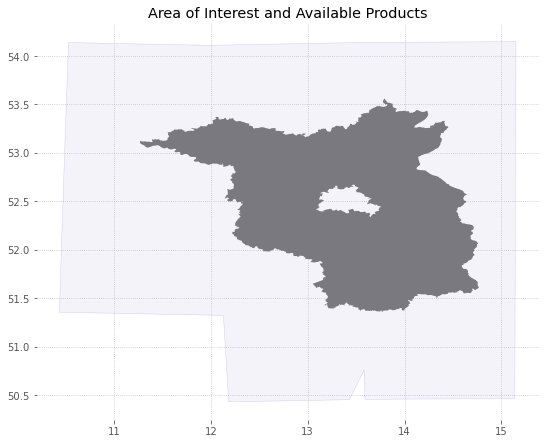

In [14]:
plot_downloaded_products(union, brandenburg, figsize=(9,9))

The algorithm worked, the entire area is comfortably covered.
We can calculate the time span over which the subselection was captured:

In [15]:
products_in_union = products.loc[:idx]
products_in_union.iloc[0]['beginposition'] - products_in_union.iloc[-1]['beginposition']

Timedelta('3 days 00:10:00')

Compare this to the repeat cycle observed in [](content:orbits):

In [16]:
products[products['orbitnumber'] == 17108].iloc[0]['beginposition'] - products[products['orbitnumber'] == 16965].iloc[0]['beginposition']

Timedelta('10 days 00:00:00')

## Considering Cloud Coverage

For the union above we did not consider cloud coverage at all.
This means that a lot of pixels in the large area of interest might not have interesting data for us:

A plot of the cloud coverage can give us an estimate of how useful the combined image would be without needing to plot it visually as described in [](01b-visualization.ipynb):

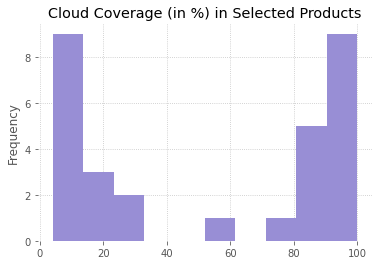

In [17]:
ax = products_in_union['cloudcoverpercentage'].plot.hist(title='Cloud Coverage (in %) in Selected Products')

The histogram shows that some of the products consist mostly of cloudy pixels - in fact, the relationship between cloudy and non-cloudy pixels is almost symmetrical.
A cloud coverage of 100% is not of much use for us because it amounts to an image that does not contain any of the surface features we are interested in.

To include only less cloudy products, a compromise on up-to-dateness hast to be made.
Setting a maximum cloud coverage of 50% increases the time delta to 15 days:

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

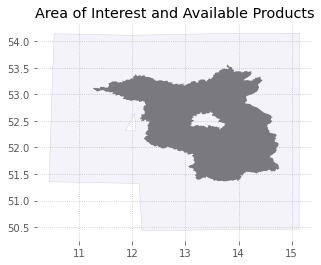

In [18]:
# restrict cloud coverage
less_cloudy_products = products[products['cloudcoverpercentage'] < 50]

# same algorithm as above
for idx, product in tqdm(less_cloudy_products.iterrows(), total=len(less_cloudy_products)):
    union = less_cloudy_products.loc[:idx].unary_union
    if union.contains(brandenburg_geometry):
        break
        
plot_downloaded_products(union, brandenburg)

In [19]:
products_in_union = less_cloudy_products.loc[:idx]
products_in_union.iloc[0]['beginposition'] - products_in_union.iloc[-1]['beginposition']

Timedelta('15 days 00:04:32')

<AxesSubplot:title={'center':'Cloud Coverage (in %) in Selected Products'}, ylabel='Frequency'>

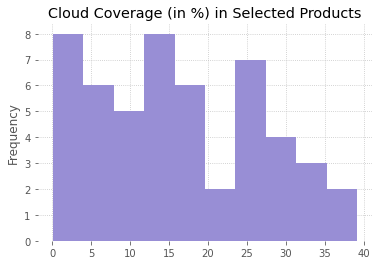

In [20]:
products_in_union['cloudcoverpercentage'].plot.hist(title='Cloud Coverage (in %) in Selected Products')

Downloads are expensive because each product to be downloaded has a size of approximately 1GB. We try to reduce the amount of products we need to download by dropping identical geometries, keeping the one with the smallest cloud cover:

In [21]:
deduplicated = products_in_union.sort_values(by='cloudcoverpercentage').drop_duplicates(subset=['geometry'])
len(deduplicated)

41

This further moves the distribution of cloud coverage in the selected products to the minimum:

<AxesSubplot:title={'center':'Cloud Coverage (in %) in Selected Products'}, ylabel='Frequency'>

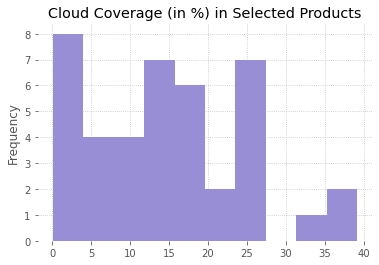

In [22]:
deduplicated['cloudcoverpercentage'].plot.hist(title='Cloud Coverage (in %) in Selected Products')